# Transparent Boundary Conditions for the dispersive part of the Serre Equation

* Definition and validation
* Objective : application to the DDM coupling Serre and NSWE


## Procedure
* Resolution of the dispersive part of the Serre equations
* Reference solution : solution computed in a larger domain
* BCs for the dispersion : TBCs --> study

In [51]:
%%writefile serreTBC.py

import sys
sys.path.append('../')
sys.path.append('../nswe')

import numpy as np
import matplotlib.pyplot as plt
import serre
import cnoidal
import nswe_wbmuscl4 as wb4

nan = float("nan")

Overwriting serreTBC.py


In [52]:
%%writefile serreTBC.py -a

def imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt,eta=0.):
    
    """
    Impose three boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array of dimensions 3x3 containing one TBC in each line, in the form
            [Position,Type,Value,Opt], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of BC : "Dirichlet"/"Neumann"/"TBC"
                ::: Value (float) : value of the BC
                ::: Opt [int,float,array] : optional coefficients for the TBC; depends on the Type 
        * h,hx,hu : informations from the last computation
        * dt
        
    - Outputs :
        * M
        * rhs
    """
    gr = 9.81
    
    ### verif number of TBCs
    #if BCs.shape[0] != 3 :
    #    sys.exit("Wrong number of BCs")
        
    ## impose BCs
    for i in range(BCs.shape[0]) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        if typ == "Dirichlet" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*h[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
        elif typ == "Neumann" :
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = -h[1]
                M[0,1] = h[0]
                rhs[0] = h[0]*h[1]/dt*(u[1]-u[0] + dt*gr*(hx[1]-hx[0]) - val*dx)
            else:
                M[pos,pos] = h[pos-1]
                M[pos,pos-1] = -h[pos]
                rhs[pos] = h[pos]*h[pos-1]/dt*(u[pos]-u[pos-1] + dt*gr*(hx[pos]-hx[pos-1]) - val*dx)
        elif typ == "Robin" :
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            M[pos,:] = 0.
            if pos == 0 or pos == -2 :
                M[pos,pos] = dt*h[pos+1]*(alpha*dx - beta)
                M[pos,pos+1] = beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos+1]*(\
                                    alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                    beta*(u[pos+1] - u[pos] + dt*gr*(hx[pos+1]-hx[pos])) - dx*val)
            elif pos == 1 or pos == -1 :
                M[pos,pos] = dt*h[pos-1]*(alpha*dx + beta)
                M[pos,pos-1] = -beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos-1]*(\
                                            alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                            beta*(u[pos] - u[pos-1] + dt*gr*(hx[pos]-hx[pos-1])) - dx*val)
        elif typ == "TBC" or typ == "TBC2" or typ == "TBC3":  ##alpha*uxx + beta*ux + gamma*u = val 

            if typ == "TBC" :
                alpha = float(BCs[i,3])
                beta = float(BCs[i,4])
                gamma = float(BCs[i,5])
            elif typ == "TBC2" : ##with time derivative
                if pos == 0 :
                    alpha = u[0]*dt
                    beta = 1. - dt*(u[1]-u[0])/dx
                    gamma = 0.
                    val = (u[1]-u[0])/dx
                elif pos == -1 :
                    alpha = u[-1]*dt
                    beta = 1. - dt*(u[-1]-u[-2])/dx
                    gamma = 0.
                    val = (u[-1]-u[-2])/dx
            elif typ == "TBC3" : ##with time derivative : ut + u + ux + uxx= 0
                if pos == 0 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[0]
                elif pos == -1 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[-1]
            M[pos,:] = 0.
            if pos == 0:
                c0 = alpha/(dx*dx) - beta/dx + gamma
                c1 = -2.*alpha/(dx*dx) + beta/dx
                c2 = alpha/(dx*dx)
                M[0,0] = -dt/h[0]*c0
                M[0,1] = -dt/h[1]*c1
                M[0,2] = -dt/h[2]*c2
                rhs[0] =val - (u[0]+dt*gr*(hx[0]+eta))*c0 - (u[1]+dt*gr*(hx[1]+eta))*c1 - (u[2]+dt*gr*(hx[2]+eta))*c2
            elif pos == 1 :
                c0 = alpha/(dx*dx) - beta/dx
                c1 = -2.*alpha/(dx*dx) + beta/dx + gamma
                c2 = alpha/(dx*dx)
                M[1,0] = -dt/h[0]*c0
                M[1,1] = -dt/h[1]*c1
                M[1,2] = -dt/h[2]*c2
                rhs[1] =val - (u[0]+dt*gr*(hx[0]+eta))*c0 - (u[1]+dt*gr*(hx[1]+eta))*c1 - (u[2]+dt*gr*(hx[2]+eta))*c2
            elif pos == -1 :
                c0 = alpha/(dx*dx) + beta/dx + gamma
                c1 = -2.*alpha/(dx*dx) - beta/dx
                c2 = alpha/(dx*dx)
                M[pos,pos] = -dt/h[pos]*c0
                M[pos,pos-1] = -dt/h[pos-1]*c1
                M[pos,pos-2] = -dt/h[pos-2]*c2
                rhs[pos] =val - (u[pos]+dt*gr*(hx[pos]+eta))*c0 - (u[pos-1]+dt*gr*(hx[pos-1]+eta))*c1 - \
                                (u[pos-2]+dt*gr*(hx[pos-2]+eta))*c2
            elif pos == -2 :
                c0 = alpha/(dx*dx) + beta/dx
                c1 = -2.*alpha/(dx*dx) - beta/dx + gamma
                c2 = alpha/(dx*dx)
                M[pos,pos+1] = -dt/h[pos+1]*c0
                M[pos,pos] = -dt/h[pos]*c1
                M[pos,pos-1] = -dt/h[pos-1]*c2
                rhs[pos] =val - (u[pos+1]+dt*gr*(hx[pos+1]+eta))*c0 - (u[pos]+dt*gr*(hx[pos]+eta))*c1 -\
                                (u[pos-1]+dt*gr*(hx[pos-1]+eta))*c2
        else :
            sys.exit("Wrong type of TBC!! Please use Dirichlet/Neumann/TBC")
    return M,rhs

Appending to serreTBC.py


In [53]:
%%writefile serreTBC.py -a

def imposeBCDispersiveLinear(M,rhs,BCs,h,u,hx,hu,dx,dt):
    
    """
    Impose three boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array of dimensions 3x3 containing one TBC in each line, in the form
            [Position,Type,Value,Opt], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of BC : "Dirichlet"/"Neumann"/"TBC"
                ::: Value (float) : value of the BC
                ::: Opt [int,float,array] : optional coefficients for the TBC; depends on the Type 
        * h,hx,hu : informations from the last computation
        * dt
        
    - Outputs :
        * M
        * rhs
    """
    gr = 9.81
    
    ### verif number of TBCs
    #if BCs.shape[0] != 3 :
    #    sys.exit("Wrong number of BCs")
        
    ## impose BCs
    for i in range(BCs.shape[0]) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        if typ == "Dirichlet" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*h[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
        elif typ == "Neumann" :
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = -h[1]
                M[0,1] = h[0]
                rhs[0] = h[0]*h[1]/dt*(u[1]-u[0] + dt*gr*(hx[1]-hx[0]) - val*dx)
            else:
                M[pos,pos] = h[pos-1]
                M[pos,pos-1] = -h[pos]
                rhs[pos] = h[pos]*h[pos-1]/dt*(u[pos]-u[pos-1] + dt*gr*(hx[pos]-hx[pos-1]) - val*dx)
        elif typ == "Robin" :
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            M[pos,:] = 0.
            if pos == 0 or pos == -2 :
                M[pos,pos] = alpha - beta/dx
                M[pos,pos+1] = beta/dx
                rhs[pos] = val
            elif pos == 1 or pos == -1 :
                M[pos,pos] = alpha + beta/dx
                M[pos,pos-1] = -beta/dx
                rhs[pos] = val
        elif typ == "TBC" or typ == "TBC2" or typ == "TBC3":  ##alpha*uxx + beta*ux + gamma*u = val 

            if typ == "TBC" :
                alpha = float(BCs[i,3])
                beta = float(BCs[i,4])
                gamma = float(BCs[i,5])
            elif typ == "TBC2" : ##with time derivative
                if pos == 0 :
                    alpha = u[0]*dt
                    beta = 1. - dt*(u[1]-u[0])/dx
                    gamma = 0.
                    val = (u[1]-u[0])/dx
                elif pos == -1 :
                    alpha = u[-1]*dt
                    beta = 1. - dt*(u[-1]-u[-2])/dx
                    gamma = 0.
                    val = (u[-1]-u[-2])/dx
            elif typ == "TBC3" : ##with time derivative : ut + u + ux + uxx= 0
                if pos == 0 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[0]
                elif pos == -1 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[-1]
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = alpha/(dx*dx) - beta/dx + gamma
                M[0,1] = -2.*alpha/(dx*dx) + beta/dx
                M[0,2] = alpha/(dx*dx)
                rhs[0] = val
            elif pos == 1 :
                M[1,0] = alpha/(dx*dx) - beta/dx
                M[1,1] = -2.*alpha/(dx*dx) + beta/dx + gamma
                M[1,2] = alpha/(dx*dx)
                rhs[1] = val
            elif pos == -1 :
                M[-1,-1] = alpha/(dx*dx) + beta/dx + gamma
                M[-1,-2] = -2.*alpha/(dx*dx) - beta/dx
                M[-1,-3] = alpha/(dx*dx)
                rhs[-1] = val
            elif pos == -2 :
                M[-2,-1] = alpha/(dx*dx) + beta/dx 
                M[-2,-2] = -2.*alpha/(dx*dx) - beta/dx + gamma
                M[-2,-3] = alpha/(dx*dx)
                rhs[-2] = val
            sys.exit("Wrong type of TBC!! Please use Dirichlet/Neumann/TBC")
    return M,rhs

Appending to serreTBC.py


In [54]:
%%writefile serreTBC.py -a

def EFDSolverFM4(h,u,dx,dt,order,BCs,periodic=False,ng=2,side="left",href=None,uref=None,eta=0.):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    MODIFICATION : imposition of BCs
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81

    hu = h*u

    order=2
    ux = serre.get1d(u,dx,periodic,order=order)
    uxx = serre.get2d(u,dx,periodic,order=order)
    uux = u*ux
    uuxdx = serre.get1d(uux,dx,periodic,order=order)
    hx = serre.get1d(h,dx,periodic,order=order)
    hxx = serre.get2d(h,dx,periodic,order=order)
    h2x = serre.get1d(h*h,dx,periodic,order=order)
    hhx = h*hx
        
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx + eta*eta*h*u*ux + eta*eta*(hx+eta)*u*u
    rhs = gr*h*hx + h*Q + gr*h*eta      
     
    d0 = 1. + hx*hx/3. + h*hxx/3. + 5.*h*h/(6.*dx*dx) + eta*(hx+eta)
    dp1 = -2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = +2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    dp2 = 1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dp2 = dp2[0:-2]
    dm2 = -1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dm2 = dm2[2:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2)

    M[0,:] = 0
    M[1,:] = 0
    M[-1,:] = 0
    M[-2,:] = 0

    ### Correct it (but in general these lines are replaced by the BC)
    M[0,0] = h[0]*(1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx))
    M[0,1] = h[0]*(h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx))
    M[0,2] = h[0]*(-1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx))
    M[0,3] = h[0]*(1./3.*h[0]*h[0]/(dx*dx))

    M[1,1] = h[1]*(1. - 3./4.*h2x[1]/dx - 2./3.*h[1]*h[1]/(dx*dx))
    M[1,2] = h[1]*(h2x[1]/dx + 5./3.*h[1]*h[1]/(dx*dx))
    M[1,3] = h[1]*(-1./4.*h2x[1]/dx - 4./3.*h[1]*h[1]/(dx*dx))
    M[1,4] = h[1]*(1./3.*h[1]*h[1]/(dx*dx))    
    
    M[-1,-1] = h[-1]*(1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-2] = h[-1]*(-h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-3] = h[-1]*(1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-4] = h[-1]*(1./3.*h[-1]*h[-1]/(dx*dx))
      
    M[-2,-2] = h[-2]*(1. + 3./4.*h2x[-2]/dx - 2./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-3] = h[-2]*(-h2x[-2]/dx + 5./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-4] = h[-2]*(1./4.*h2x[-2]/dx - 4./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-5] = h[-2]*(1./3.*h[-2]*h[-2]/(dx*dx))
    ######

    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    M,rhs = imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt,eta=eta)

    z = np.linalg.solve(M,rhs)
    hu2 = hu + dt*(gr*h*(hx+eta)-z)
    
    return hu2/h

Appending to serreTBC.py


In [55]:
%%writefile serreTBC.py -a

def linearEFDSolverFM(h,u,dx,dt,order,BCs,periodic=False,ng=2,side="left",href=None,uref=None,h0=None,u0=None):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    MODIFICATION : imposition of BCs
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81

    hu = h*u

    order=2
    uxxx = serre.get3d(u,dx,periodic,order=order)
    uxx = serre.get2d(u,dx,periodic,order=order)
    hx = serre.get1d(h,dx,periodic,order=order)
    
    rhs = u-h0*h0/3.*uxx
    
    d0 = (1. + 5.*h0*h0/(6.*dx*dx))*np.ones_like(u)
    dp1 = h0*h0/(3*dx*dx)*(- 4./3. + 13./8.*dt*u0/dx)*np.ones_like(u)
    dp1 = dp1[0:-1]
    dm1 = h0*h0/(3*dx*dx)*(+ 4./3. - 13./8.*dt*u0/dx)*np.ones_like(u)
    dm1 = dm1[1:]
    dp2 = h0*h0/(3*dx*dx)*(- 1./12. -1.*dt*u0/dx)*np.ones_like(u)
    dp2 = dp2[0:-2]
    dm2 =  h0*h0/(3*dx*dx)*(- 1./12. + 1.*dt*u0/dx)*np.ones_like(u)
    dm2 = dm2[2:]
    dp3 = h0*h0/(3*dx*dx)*(+1./8.*dt*u0/dx)*np.ones_like(u)
    dp3 = dp3[0:-3]
    dm3 = h0*h0/(3*dx*dx)*(-1./8.*dt*u0/dx)*np.ones_like(u)
    dm3 = dm3[3:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2) + \
        np.diag(dp3,3) + np.diag(dm3,-3)

    M[0,:] = 0
    M[1,:] = 0
    M[2,:] = 0
    M[-1,:] = 0
    M[-2,:] = 0
    M[-3,:] = 0

    ### Correct it (but in general these lines are replaced by the BC)
    M[0,0] = 1. + h0*h0/(3.*dx*dx)* (2. - 5./2.*dt*u0/dx)
    M[0,1] = h0*h0/(3.*dx*dx)* (-5. + 9.*dt*u0/dx)
    M[0,2] = h0*h0/(3.*dx*dx)* (4. - 12.*dt*u0/dx)
    M[0,3] = h0*h0/(3.*dx*dx)* (-1. + 7.*dt*u0/dx)
    M[0,4] = h0*h0/(3.*dx*dx)* (-3./2.*dt*u0/dx)
    
    M[1,1] = 1. + h0*h0/(3.*dx*dx)* (2. - 5./2.*dt*u0/dx)
    M[1,2] = h0*h0/(3.*dx*dx)* (-5. + 9.*dt*u0/dx)
    M[1,3] = h0*h0/(3.*dx*dx)* (4. - 12.*dt*u0/dx)
    M[1,4] = h0*h0/(3.*dx*dx)* (-1. + 7.*dt*u0/dx)
    M[1,5] = h0*h0/(3.*dx*dx)* (-3./2.*dt*u0/dx)
    
    M[2,2] = 1. + h0*h0/(3.*dx*dx)* (2. - 5./2.*dt*u0/dx)
    M[2,3] = h0*h0/(3.*dx*dx)* (-5. + 9.*dt*u0/dx)
    M[2,4] = h0*h0/(3.*dx*dx)* (4. - 12.*dt*u0/dx)
    M[2,5] = h0*h0/(3.*dx*dx)* (-1. + 7.*dt*u0/dx)
    M[2,6] = h0*h0/(3.*dx*dx)* (-3./2.*dt*u0/dx)
    
    M[-1,-1] = 1. + h0*h0/(3.*dx*dx)* (2. + 5./2.*dt*u0/dx)
    M[-1,-2] = h0*h0/(3.*dx*dx)* (-5. - 9.*dt*u0/dx)
    M[-1,-3] = h0*h0/(3.*dx*dx)* (4. + 12.*dt*u0/dx)
    M[-1,-4] = h0*h0/(3.*dx*dx)* (-1. - 7.*dt*u0/dx)
    M[-1,-5] = h0*h0/(3.*dx*dx)* (+3./2.*dt*u0/dx)
      
    M[-2,-2] = 1. + h0*h0/(3.*dx*dx)* (2. + 5./2.*dt*u0/dx)
    M[-2,-3] = h0*h0/(3.*dx*dx)* (-5. - 9.*dt*u0/dx)
    M[-2,-4] = h0*h0/(3.*dx*dx)* (4. + 12.*dt*u0/dx)
    M[-2,-5] = h0*h0/(3.*dx*dx)* (-1. - 7.*dt*u0/dx)
    M[-2,-6] = h0*h0/(3.*dx*dx)* (+3./2.*dt*u0/dx)
    
    M[-3,-3] = 1. + h0*h0/(3.*dx*dx)* (2. + 5./2.*dt*u0/dx)
    M[-3,-4] = h0*h0/(3.*dx*dx)* (-5. - 9.*dt*u0/dx)
    M[-3,-5] = h0*h0/(3.*dx*dx)* (4. + 12.*dt*u0/dx)
    M[-3,-6] = h0*h0/(3.*dx*dx)* (-1. - 7.*dt*u0/dx)
    M[-3,-7] = h0*h0/(3.*dx*dx)* (+3./2.*dt*u0/dx)
    ######

    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    M,rhs = imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt)

    z = np.linalg.solve(M,rhs)
    hu2 = hu + dt*(gr*h*hx-z)
    
    return hu2/h

Appending to serreTBC.py


In [56]:
%%writefile serreTBC.py -a

def solveDispersiveSerre(u,href,t0,tmax,dt,dx,BCconfig,uref=None,debug=False,idxlims=None):
    
    t = t0
    it = 0 ## index of timestep
    grav = 9.8
    
    ## store solutions of all timesteps
    uall = u
    tall = np.ones(1)*t0
    
    while t < tmax:
        
        ## h(t) = referential solution
        h = href[:,it]
        hu = h*u

        FDorder = 4 
        
        if debug :
            BCconfig[0,2] = uref[idxlims[0],it+1]
            BCconfig[1,2] = uref[idxlims[1],it+1]
            BCconfig[2,2] = uref[idxlims[0]+1,it+1]
            BCconfig[3,2] = uref[idxlims[1]-1,it+1]
            BCconfig[4,2] = uref[idxlims[0]+2,it+1]
            BCconfig[5,2] = uref[idxlims[1]-2,it+1]
        u = EFDSolverFM4(h,u,dx,dt,FDorder,BCconfig)

        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
        
        t = t+dt
        it = it+1
        
    return uall,tall

Appending to serreTBC.py


In [57]:
%%writefile serreTBC.py -a

def solveLinearDispersiveSerre(u,href,t0,tmax,dt,dx,BCconfig,uref=None,debug=False,idxlims=None,h0=None,u0=None):
    
    t = t0
    it = 0 ## index of timestep
    grav = 9.8
    
    ## store solutions of all timesteps
    uall = u
    tall = np.ones(1)*t0
    
    while t < tmax:
        
        ## h(t) = referential solution
        h = href[:,it]
        hu = h*u

        FDorder = 4 
        
        if debug :
            BCconfig[0,2] = uref[idxlims[0],it+1]
            BCconfig[1,2] = uref[idxlims[1],it+1]
            BCconfig[2,2] = uref[idxlims[0]+1,it+1]
            BCconfig[3,2] = uref[idxlims[1]-1,it+1]
            BCconfig[4,2] = uref[idxlims[0]+2,it+1]
            BCconfig[5,2] = uref[idxlims[1]-2,it+1]
        u = linearEFDSolverFM(h,u,dx,dt,FDorder,BCconfig,h0=h0,u0=u0)

        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
        
        t = t+dt
        it = it+1
        
    return uall,tall

Appending to serreTBC.py


In [58]:
%%writefile serreTBC.py -a

def computeErrorTBC(u,uref,idxlims,dx,dt):
    lim1 = idxlims[0]
    lim2 = idxlims[1]
    uwind = uref[lim1:lim2+1,:]
    errDom = np.linalg.norm(u-uwind)*np.sqrt(dx*dt)
    errInt1 = np.linalg.norm(u[0,:]-uwind[0,:])*np.sqrt(dt)
    errInt2 = np.linalg.norm(u[-1,:]-uwind[-1,:])*np.sqrt(dt)
    
    return errDom,errInt1,errInt2
    

Appending to serreTBC.py


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import serre
import cnoidal
import nswe_wbmuscl4 as wb4
import sys
import serreTBC
import generalFunctions as gF

reload(serre)
reload(serreTBC)
%matplotlib inline

In [10]:
a0 = 1./2.
a1 = .1
k = 0.
g = 9.81
t0 = 0.
tmax = 7.
dt = 0.05

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

L = 3.*lam
xmin = -L
xmax = L
nx = 500
x,dx = serre.discretizeSpace(xmin,xmax,nx)
dx = np.diff(x)[0]

## reference domain
xminref = -2*L
xmaxref = 2*L
nxref = 2*nx

xref,dxref = serre.discretizeSpace(xminref,xmaxref,nxref)
dxref = np.diff(xref)[0]

tallaux = np.arange(t0,tmax+dt,dt)
hall = np.zeros((x.size,tallaux.size))
hallref = np.zeros((xref.size,tallaux.size))

t = t0
h,u = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)
href,uref = cnoidal.analyticalSolutionSolitary(xref,t,a0,a1)

## construct a solution for h
for j in range(tallaux.size):
    t = tallaux[j]
    hall[:,j],trash = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)
    hall[:,j] = hall[:,j] + np.flipud(hall[:,j])
    hallref[:,j],trash = cnoidal.analyticalSolutionSolitary(xref,t,a0,a1)
    hallref[:,j] = hallref[:,j] + np.flipud(hallref[:,j])

idxint1 = np.argmin(np.absolute(xref-x[0]))
idxint2 = np.argmin(np.absolute(xref-x[-1]))

##solve referential solution
BCconfigRef = np.array([[0,"Robin",0.,1.,0.],
                     [1,"Robin",0.,1.,0.],
                     [-1,"Robin",0.,1.,0.]]) ### Dirichlet (solution far enough from the boundaries)
uallref,tallref = serreTBC.solveDispersiveSerre(uref,hallref,t0,tmax,dt,dx,BCconfigRef)

## Debugging

In [42]:
reload(serreTBC)
## Debugging (Dirichlet condition using the values on the interface
BCconfig = np.array([[0,"Robin",0.,1.,0.],
                     [-1,"Robin",0.,1.,0.],
                     [1,"Robin",0.,1.,0.],
                     [-2,"Robin",0.,1.,0.],
                     [2,"Robin",0.,1.,0.],
                     [-3,"Robin",0.,1.,0.],]) ## Dirichlet and Neumann
uall,tall = serreTBC.solveDispersiveSerre(u,hall,t0,tmax,dt,dx,BCconfig,
                                 uref=uallref,debug=True,idxlims=np.array([idxint1,idxint2]))

errDom, errInt1, errInt2 = serreTBC.computeErrorTBC(uall,uallref,np.array([idxint1,idxint2]),dx,dt)

print(errDom, errInt1, errInt2)

## extend solution of small domain to the size of big domain (only for plotting)
uall1 = np.zeros_like(uallref)
uall1[idxint1:idxint2+1,:] = uall

umin = np.amin(uallref)
umax = np.amax(uallref)
hmin = np.amin(hallref)
hmax = np.amax(hallref)

[['0' 'Robin' '5.33629181426e-07' '1.0' '0.0']
 ['-1' 'Robin' '7.55610213124e-07' '1.0' '0.0']
 ['1' 'Robin' '5.65724478049e-07' '1.0' '0.0']
 ['-2' 'Robin' '8.01052732654e-07' '1.0' '0.0']
 ['2' 'Robin' '5.99750227061e-07' '1.0' '0.0']
 ['-3' 'Robin' '8.4922809555e-07' '1.0' '0.0']]
[   0.         -194.45005754  488.6251329  -390.90009882   97.72502385
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.        

LinAlgError: Singular matrix

*** Plotting animation ...



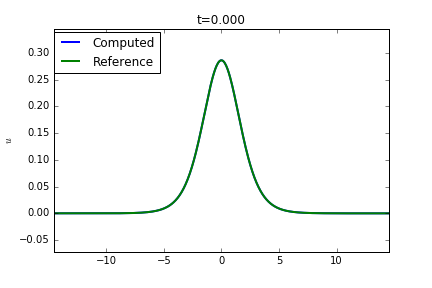
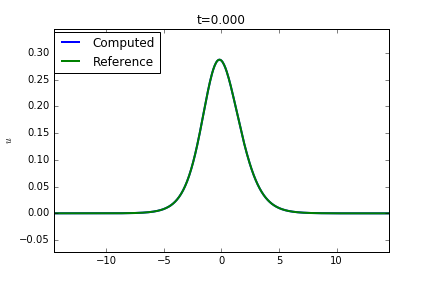
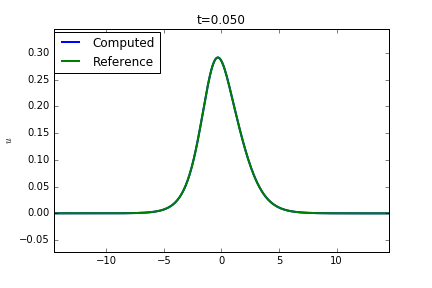
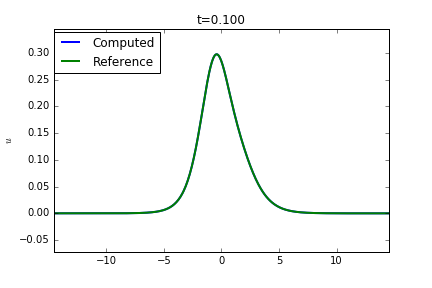
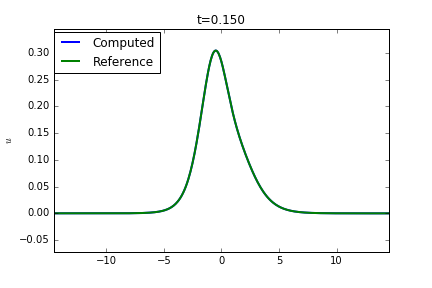
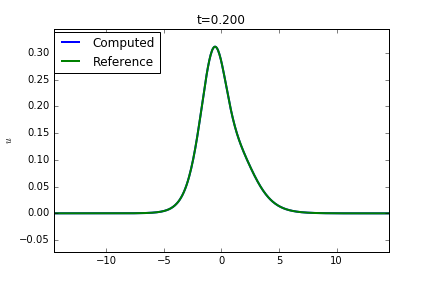
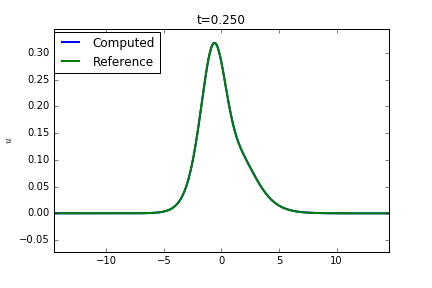
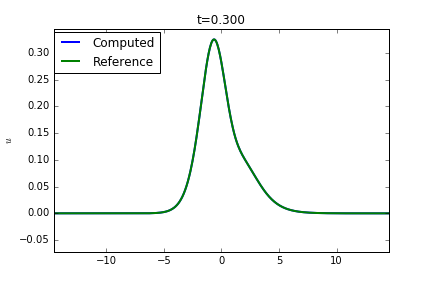
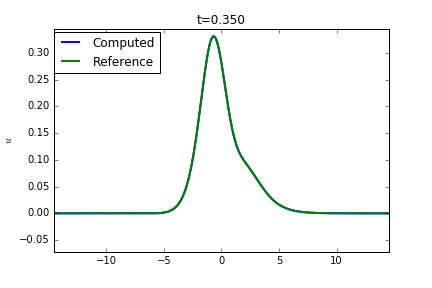
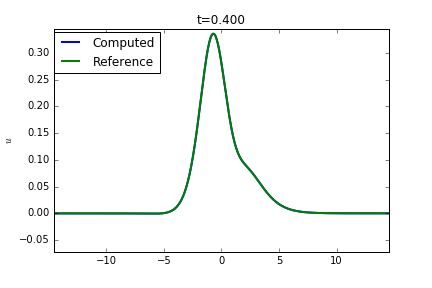
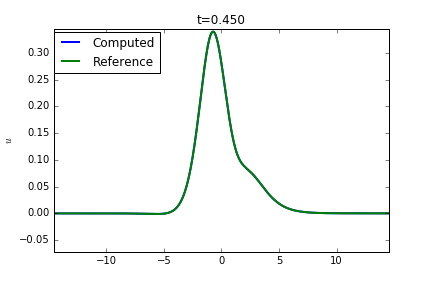
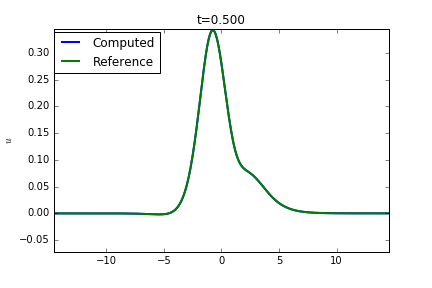
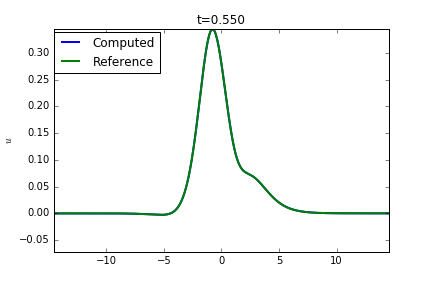
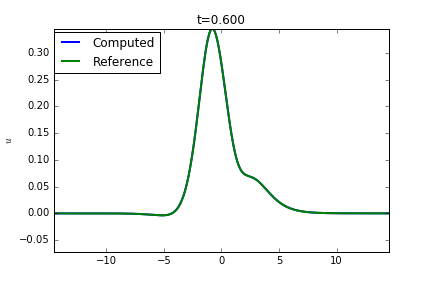
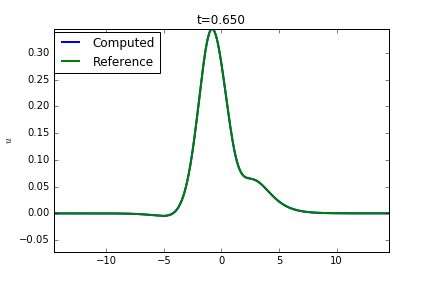
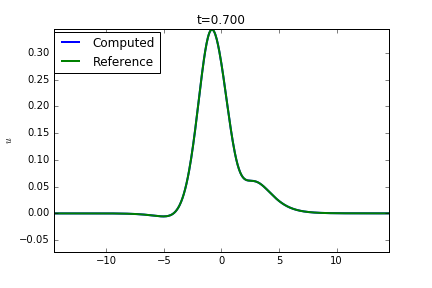
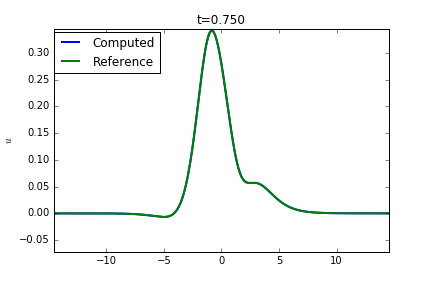
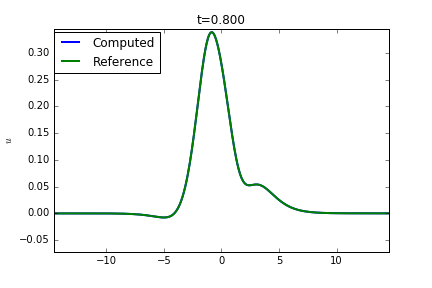
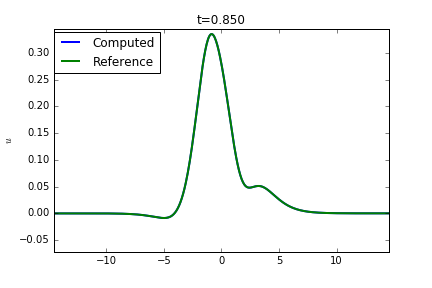
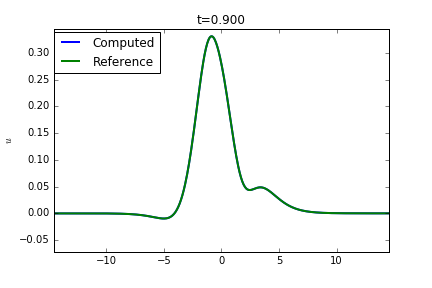
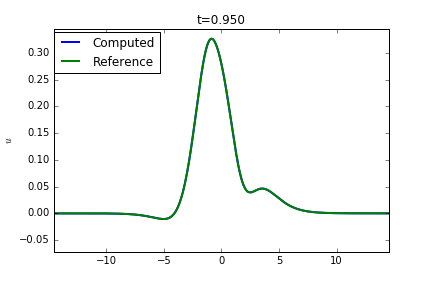
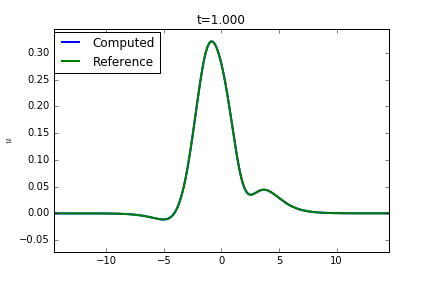
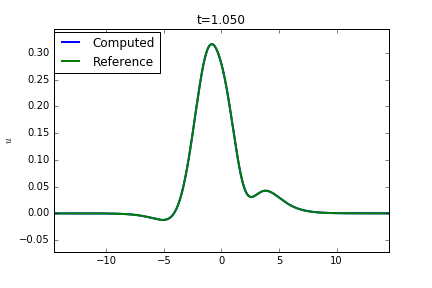
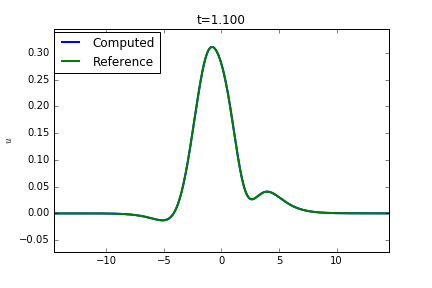
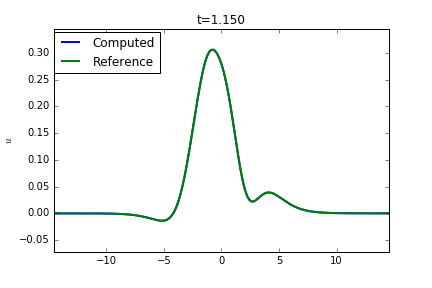
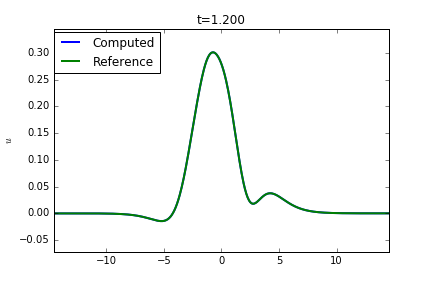
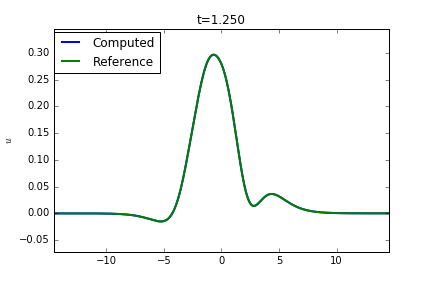
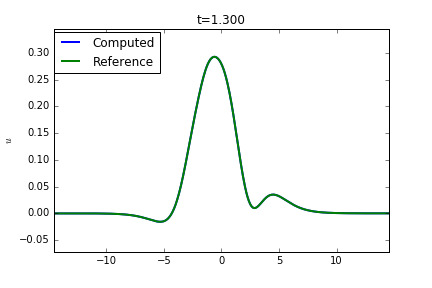
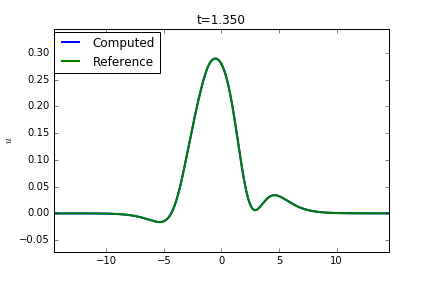
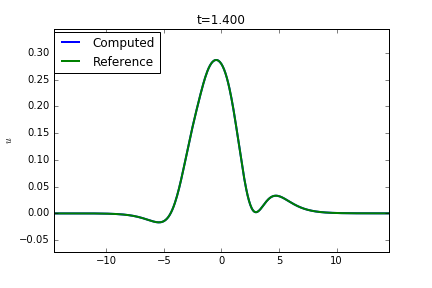
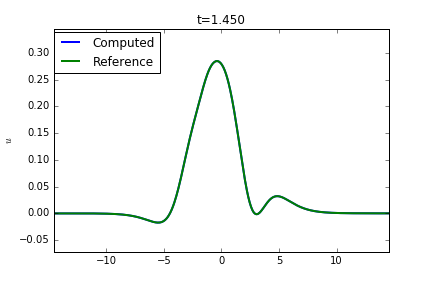
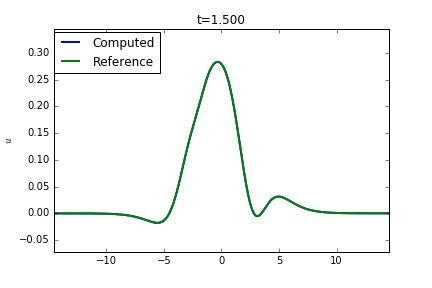
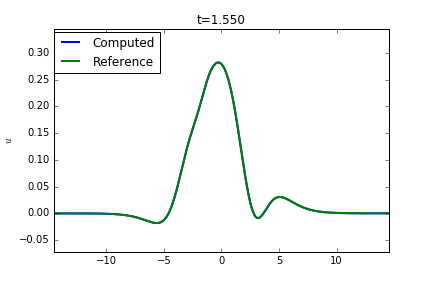
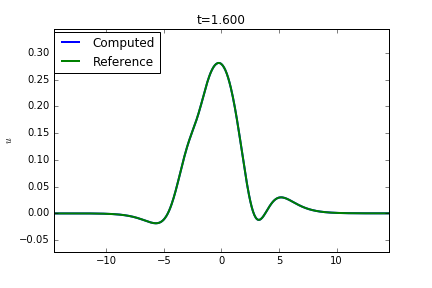
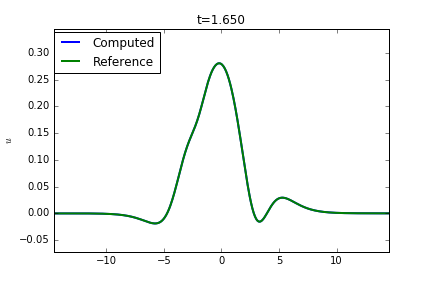
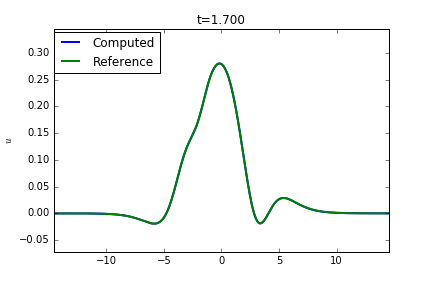
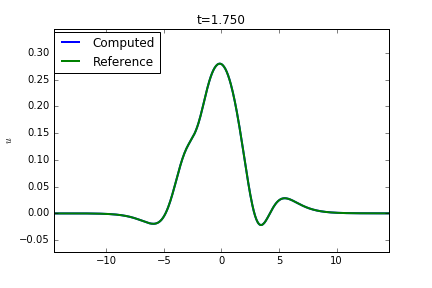
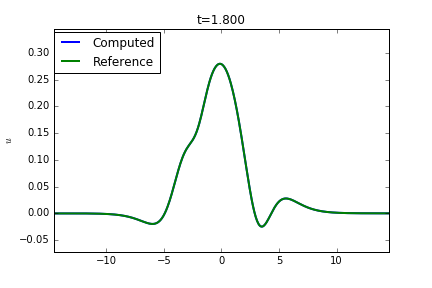
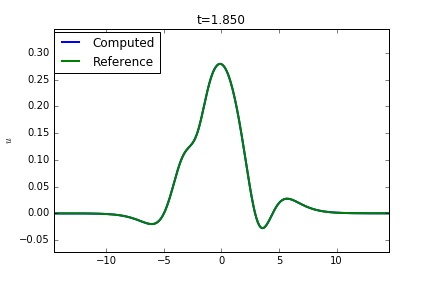
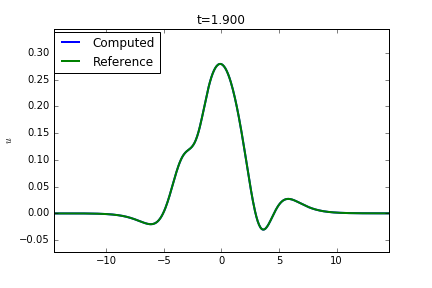
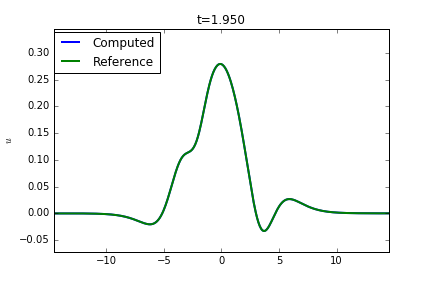
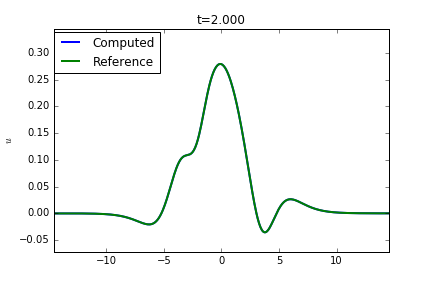
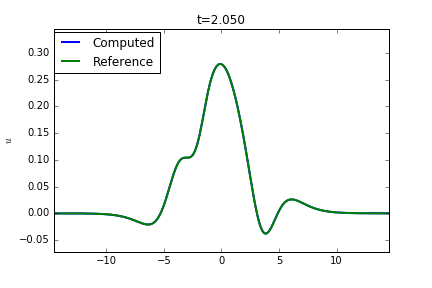
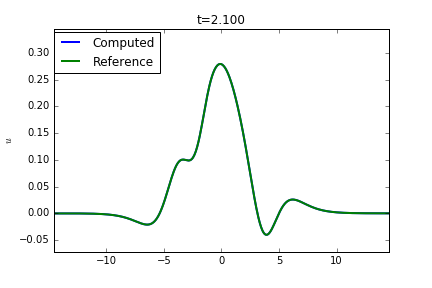
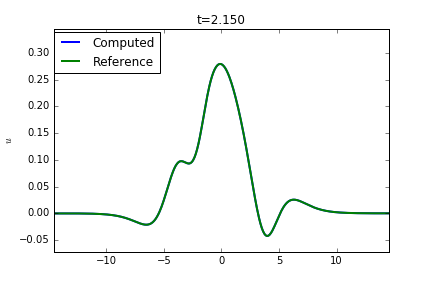
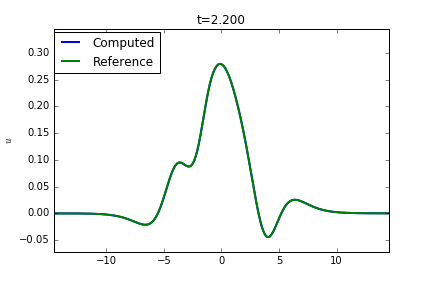
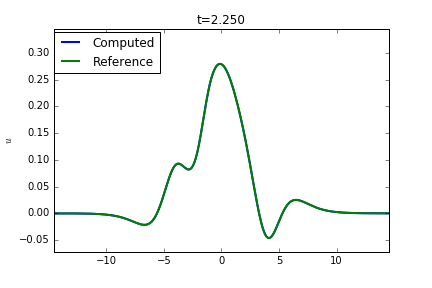
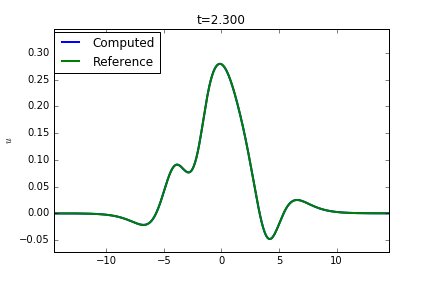
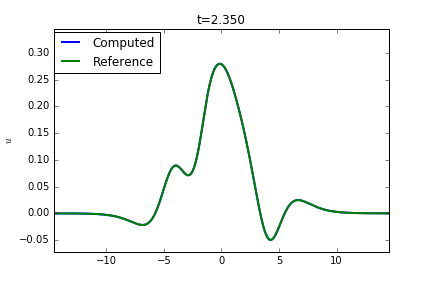
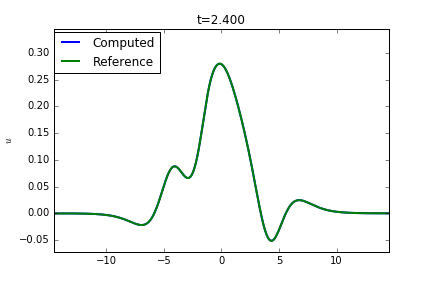
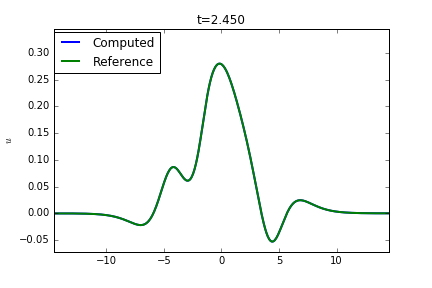
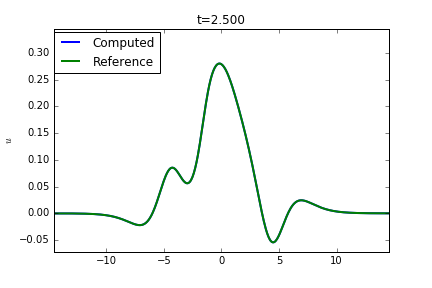
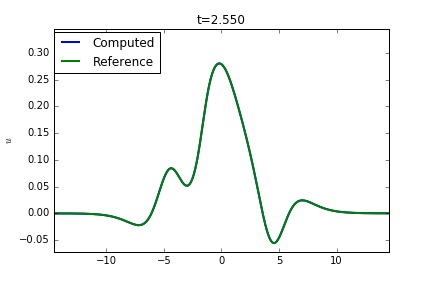
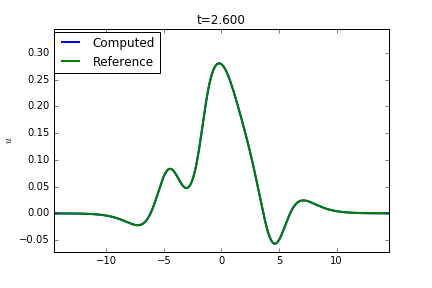
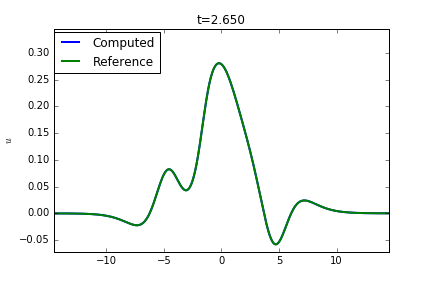
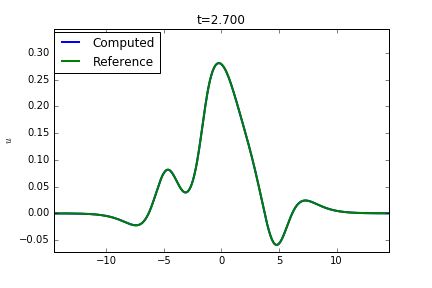
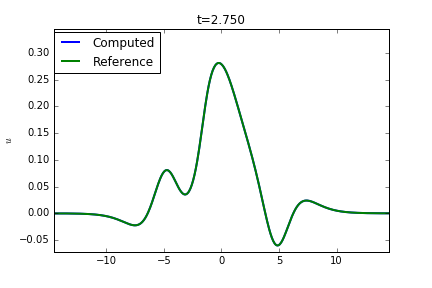
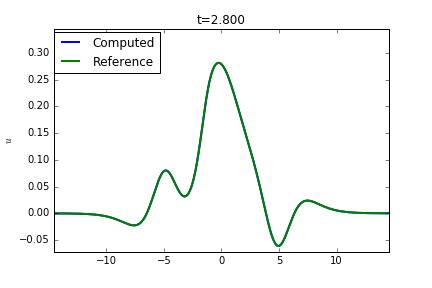
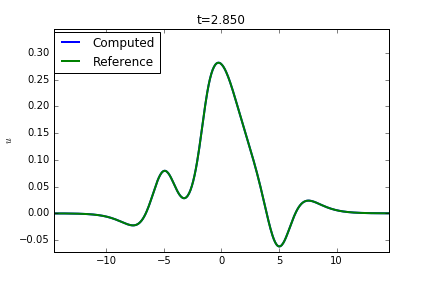
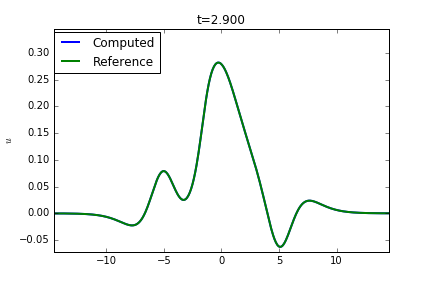
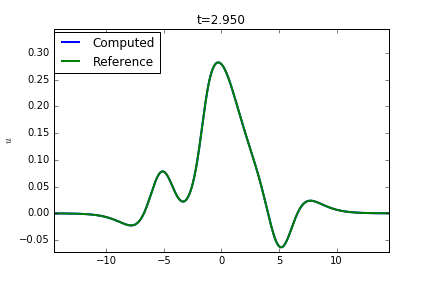
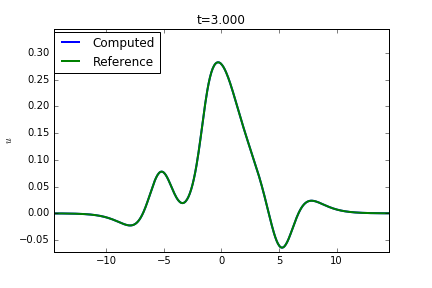
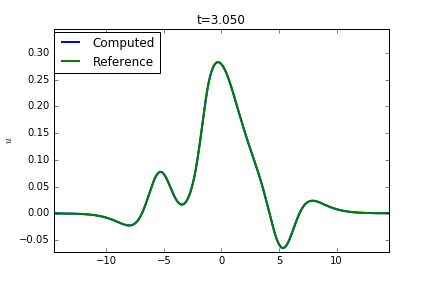
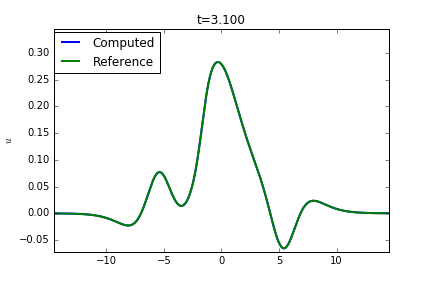
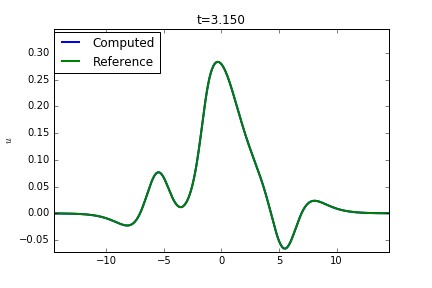
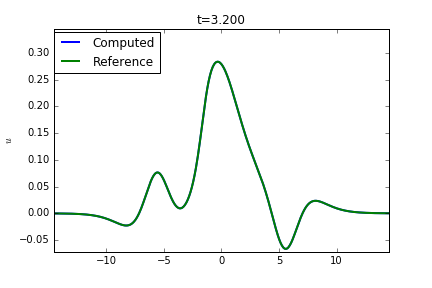
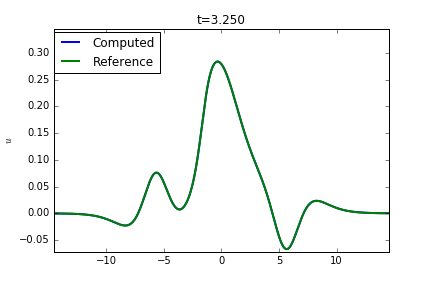
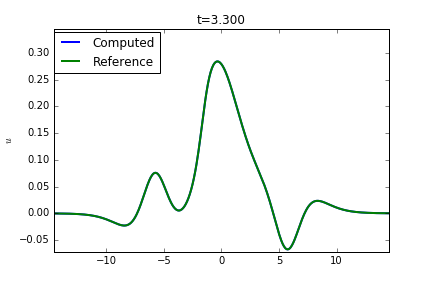
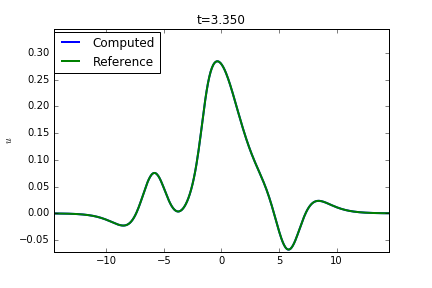
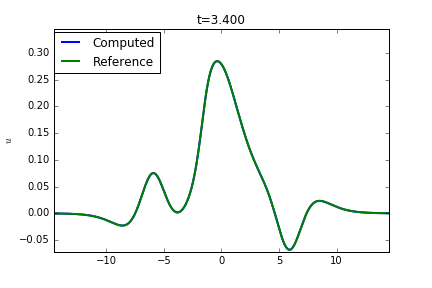
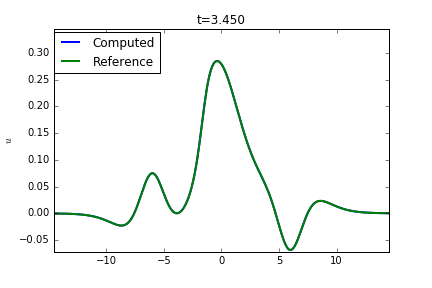
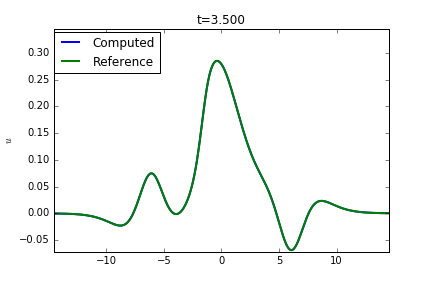
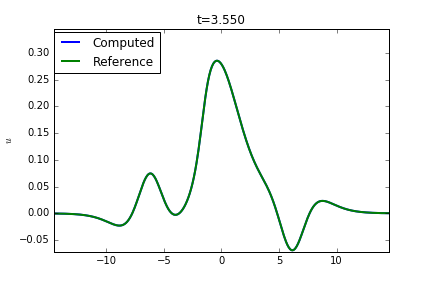
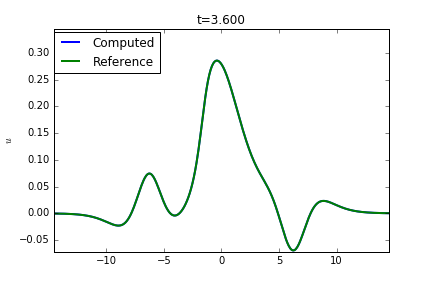
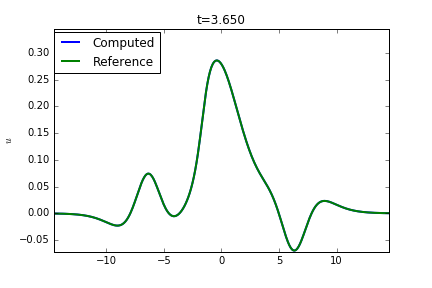
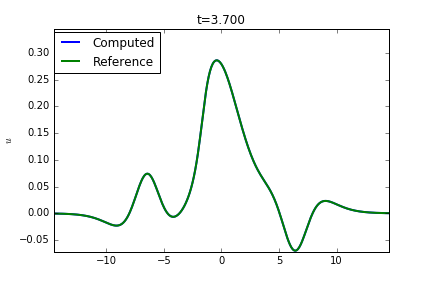
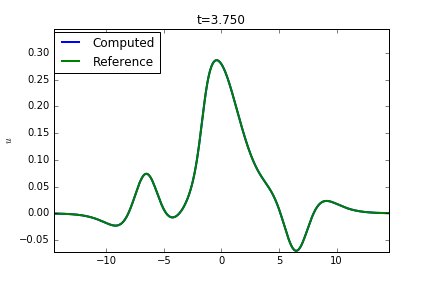
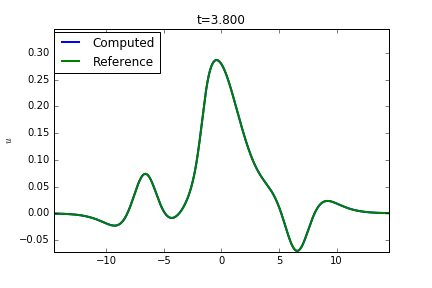
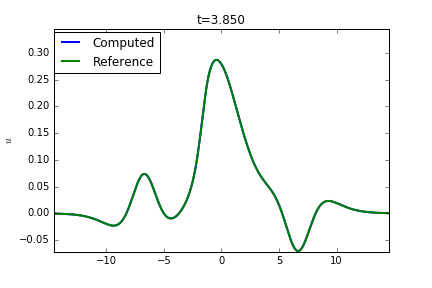
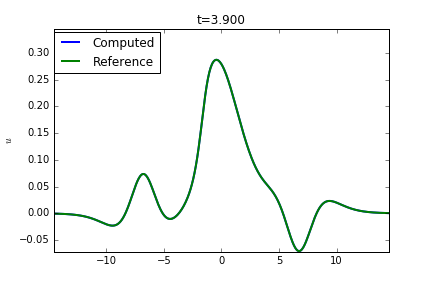
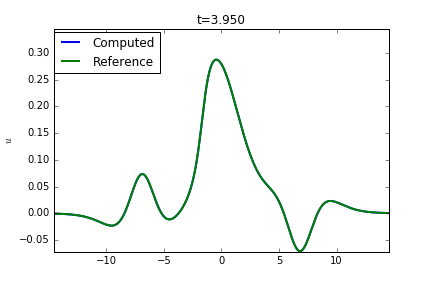
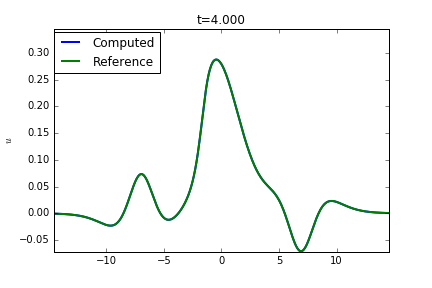
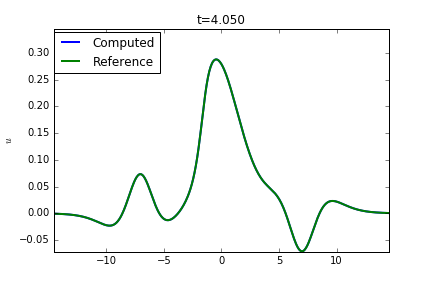
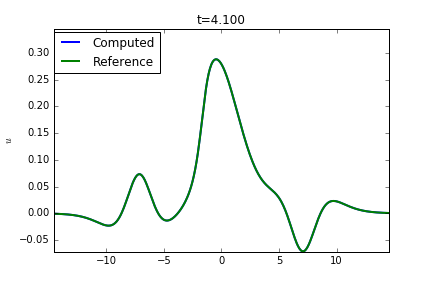
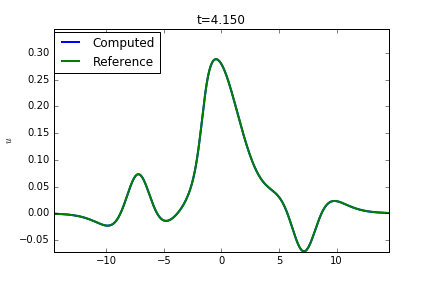
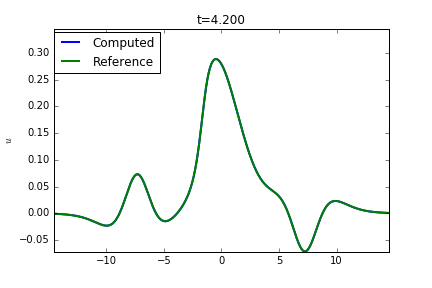
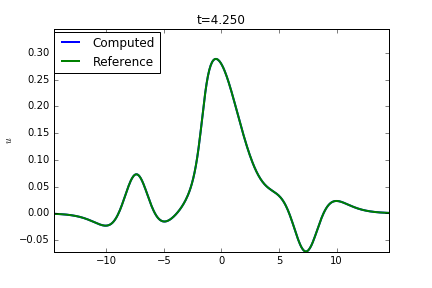
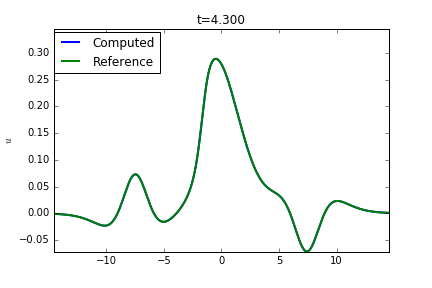
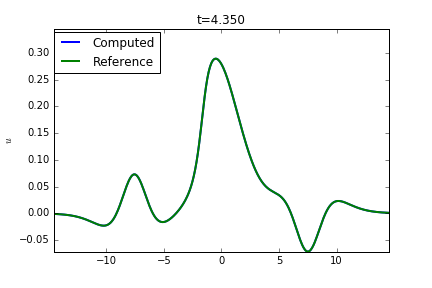
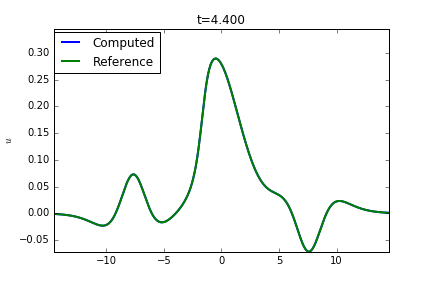
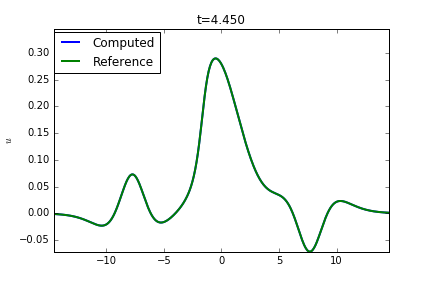
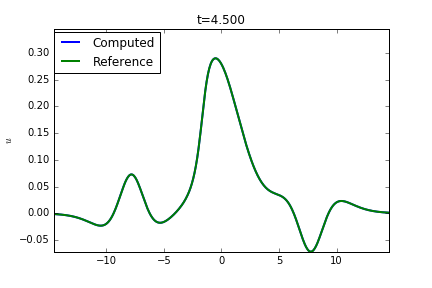
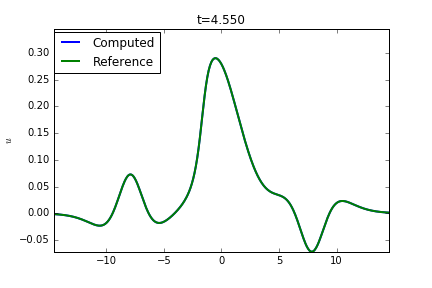
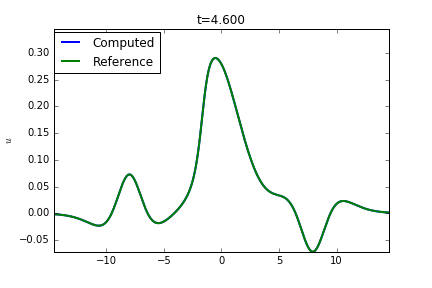
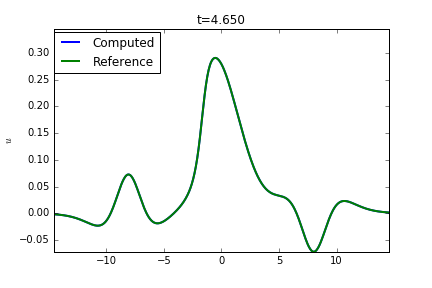
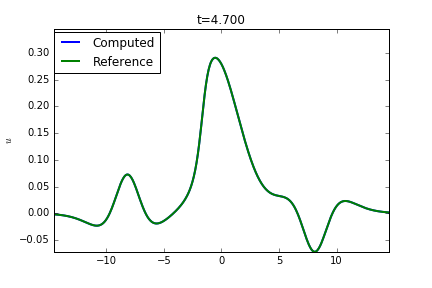
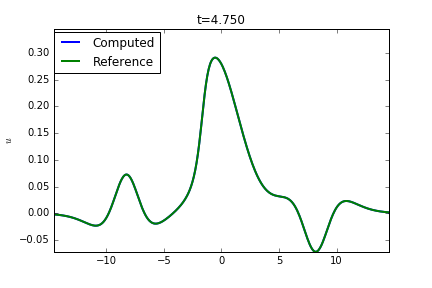
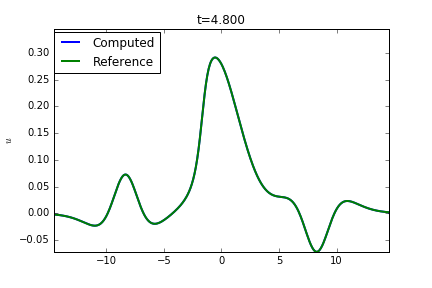
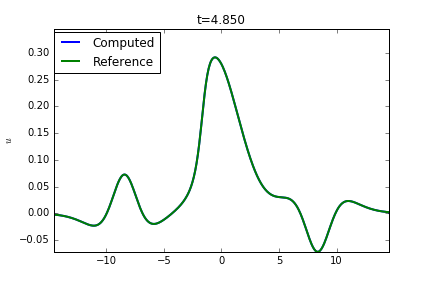
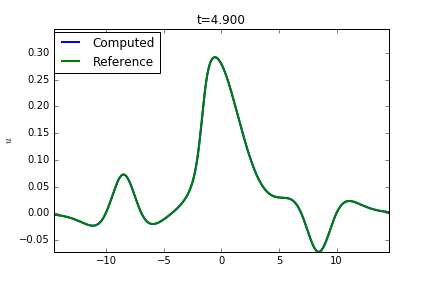
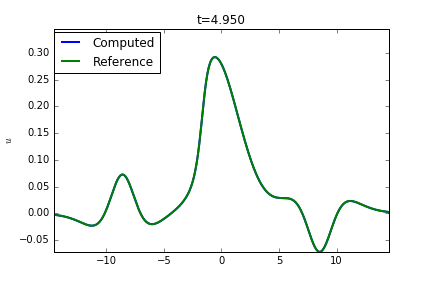
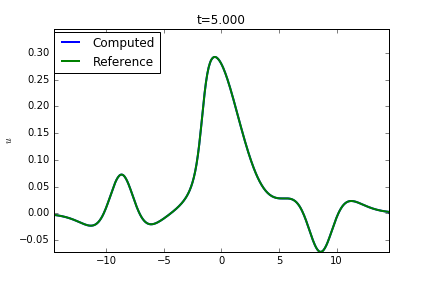
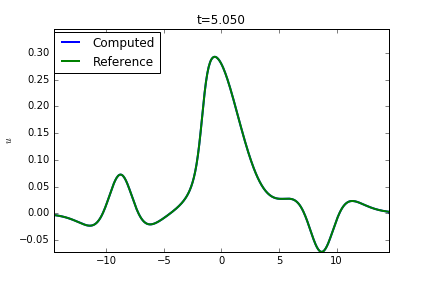
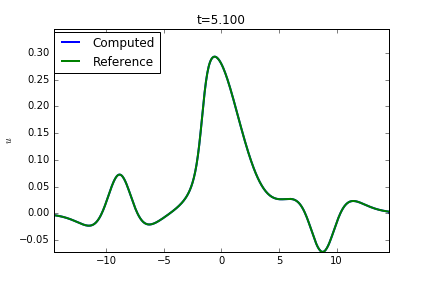
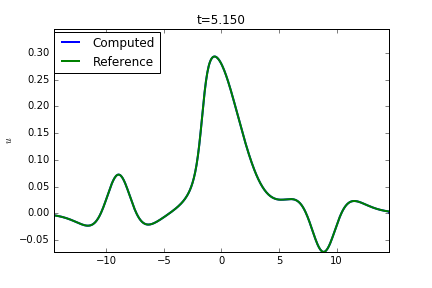
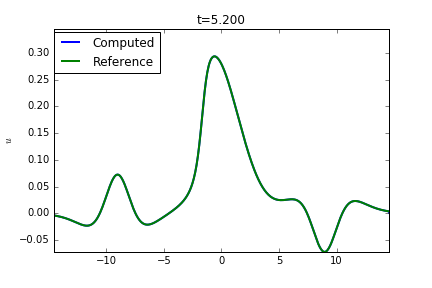
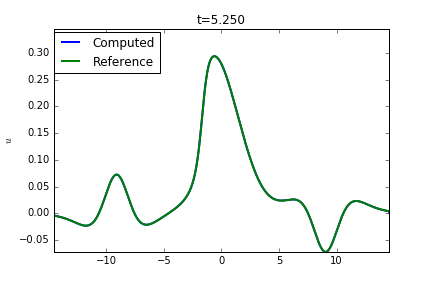
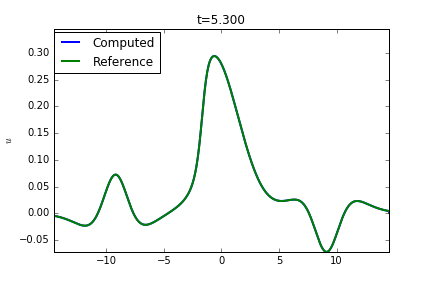
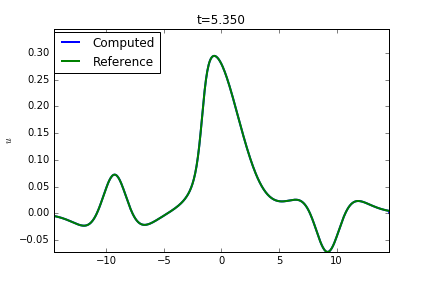
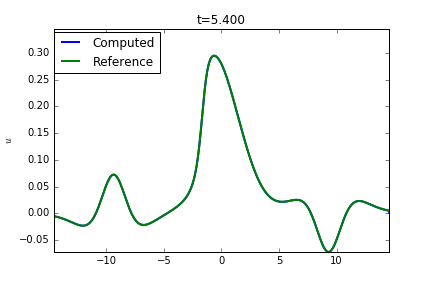
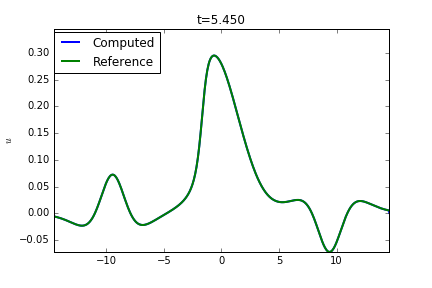
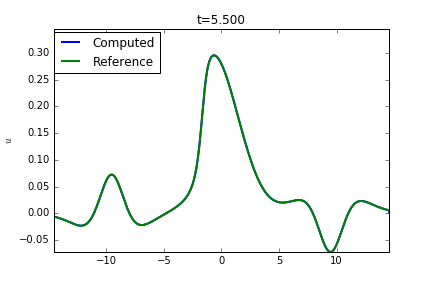
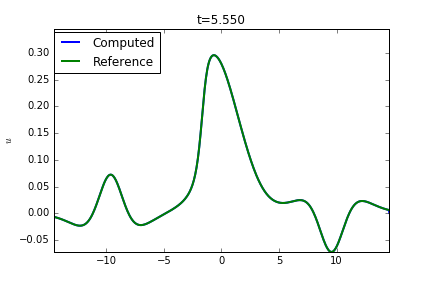
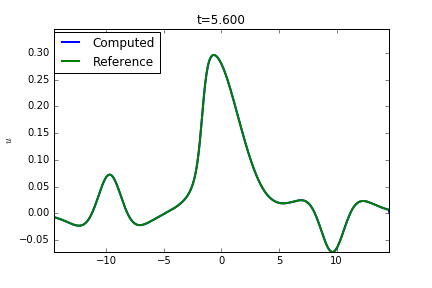
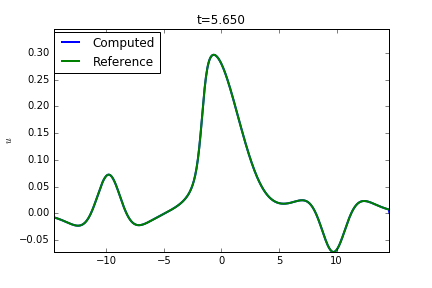
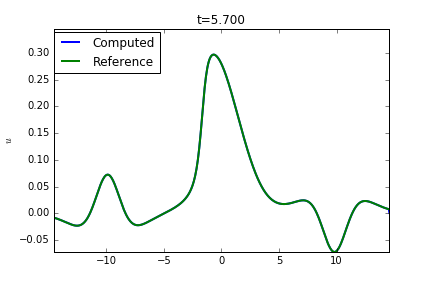
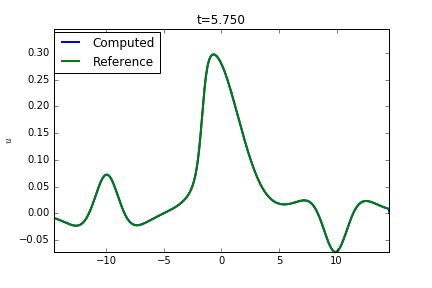
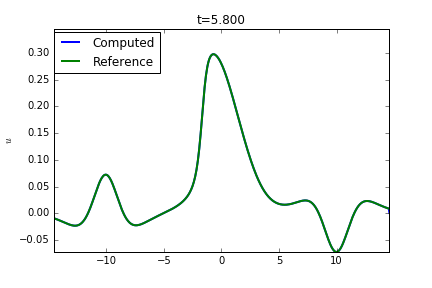
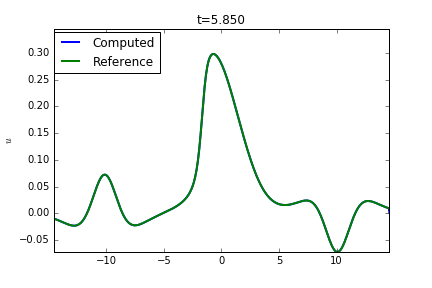
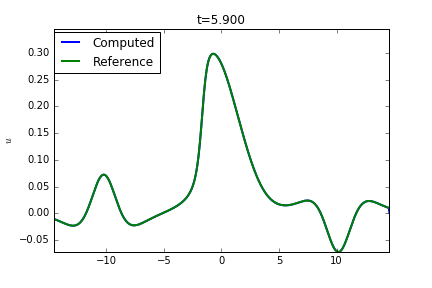
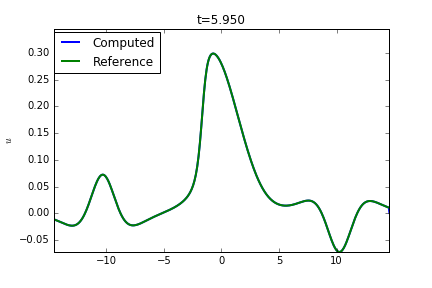
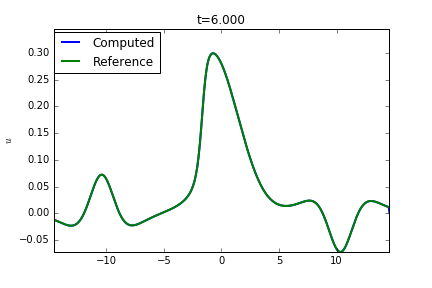
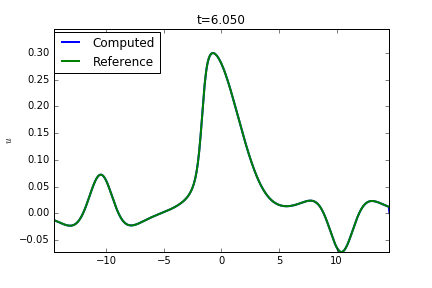
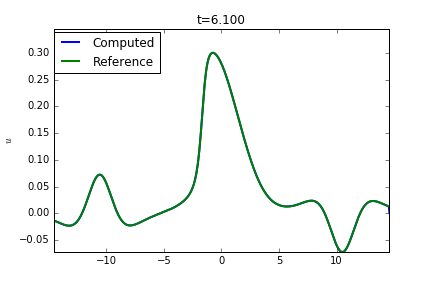
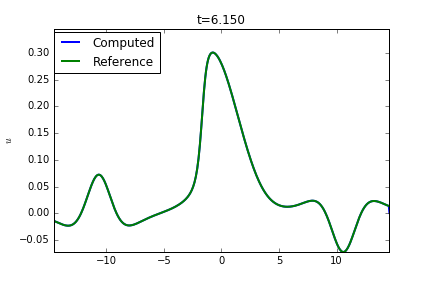
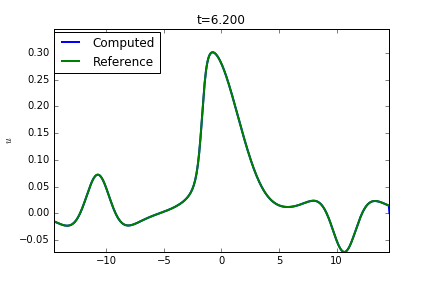
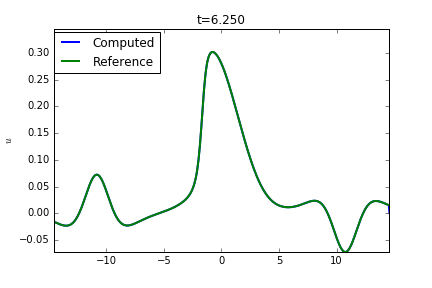
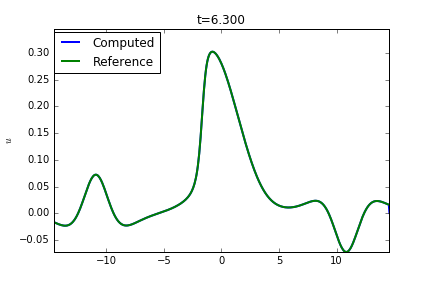
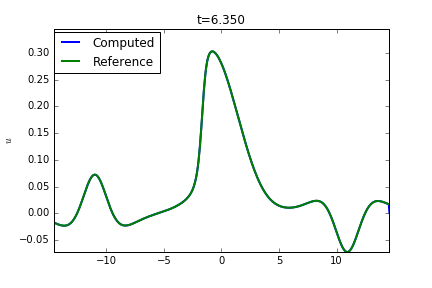
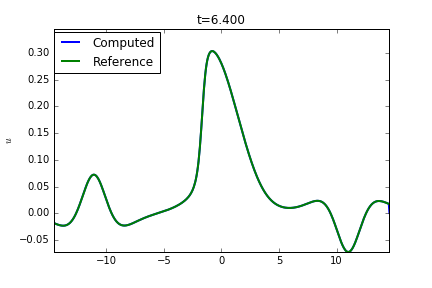
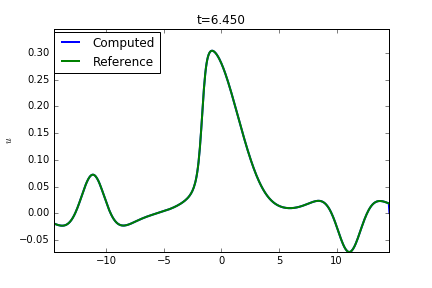
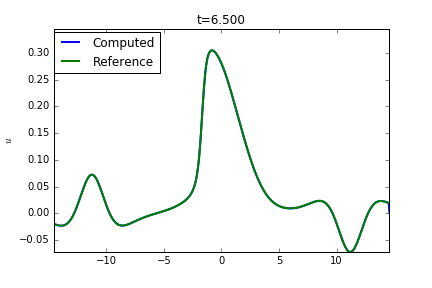
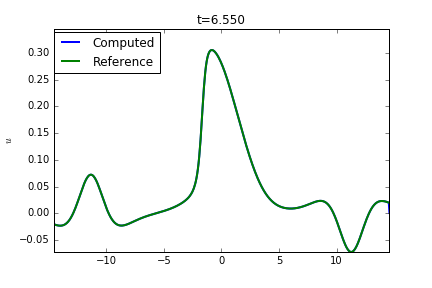
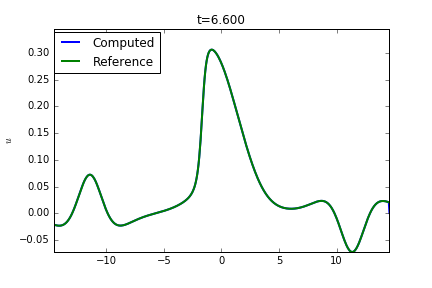
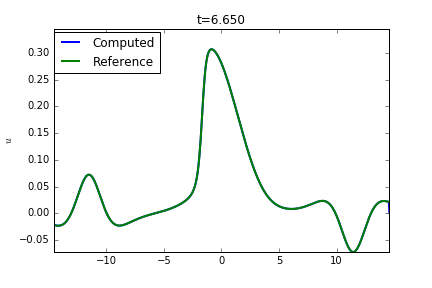
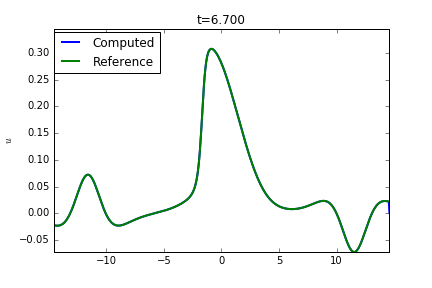
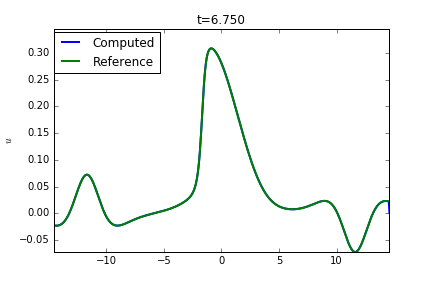
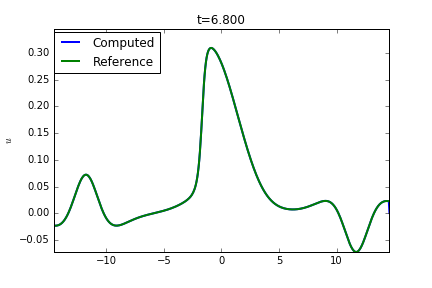
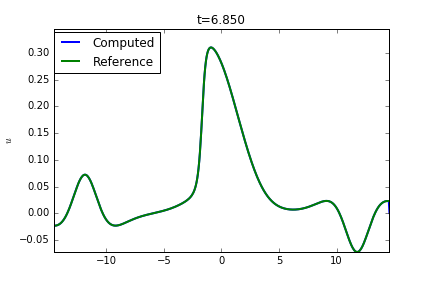
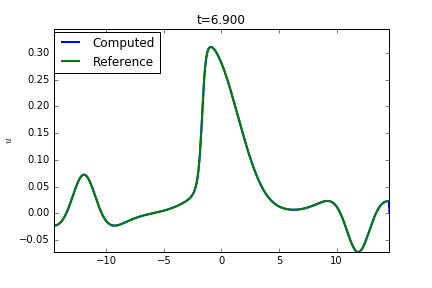
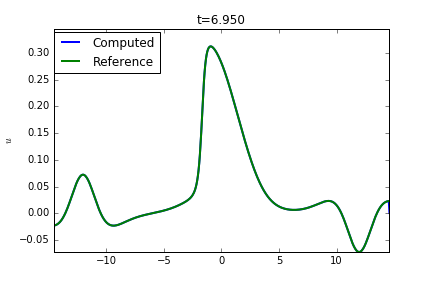
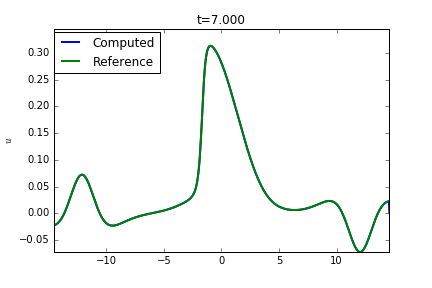

In [19]:
lb = ["Computed","Reference"]
gF.plotAnimationNSolutions(2,xref,np.array([uall1,uallref]),tall,xmin+dx,xmax-dx,umin,umax,lb,ylabel=r'$u$',location=(0.,0.8))